In [67]:
from pathlib import Path
from sklearn import model_selection
from pydicom import dcmread
import matplotlib.pyplot as plt
import cv2
import os
import csv
import random

DATASET_ROOT = Path('./L3netDemoData')

### Visualizando os dados
- dicom -> mXYX-sABCD-i.dcm (ABCD é o número da slice e i é o ID do paciente)
- masks -> i_zEFG.png (EFG é o número da slice e i é o ID do paciente)
<br>

**OBS: Será possível ver abaixo que, para esse dataset, a máscara do pulmão está invertida (horizontalmente) e a máscara de infecções além de estar invertida (verticalmente) está também rotacionada 90º para a esquerda. Após as células de leitura abaixo, colocarei células de leitura que corrigem isso.**

**OBS 2: Algumas máscaras de pulmão têm um buraco em determinas regiões infeccionadas, mas técnicas de PDI devem ser usadas pelas duas equipes para considerar tais regiões na segmentação do pulmão. Caso contrário, isso pode influenciar na precisão do modelo. A seed 96 abaixo permite visualizarmos um exemplo dessa situação na linha 5 dos plots.**


In [5]:
random.seed(96)
dicoms = random.sample(sorted(DATASET_ROOT.glob('OpenSourceDCMs/DCM*/*')), 9)
dicoms

[PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0296-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0239-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM7/m010-s0041-7.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0322-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0127-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0015-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM3/m004-s0266-3.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM9/m012-s0041-9.dcm'),
 PosixPath('L3netDemoData/OpenSourceDCMs/DCM2/m005-s0003-2.dcm')]

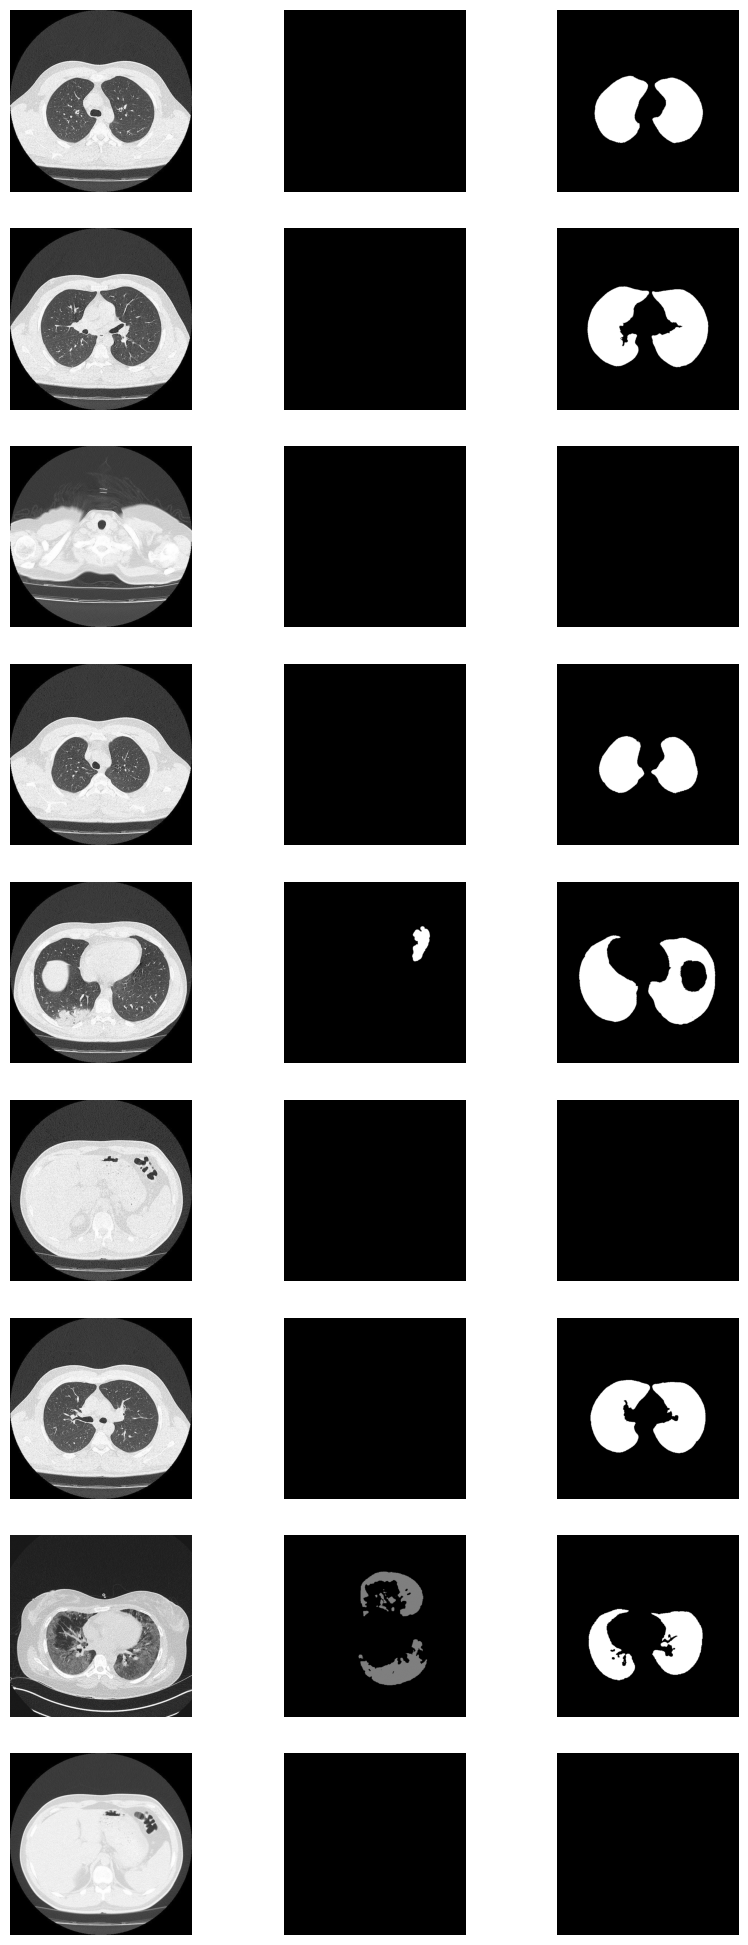

In [6]:
fig, axs = plt.subplots(9, 3, figsize=(10, 25))
i, j = 0, 0
for dicom_path in dicoms:
    infection_mask_path = DATASET_ROOT / 'InfectionMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
    lung_mask_path = DATASET_ROOT / 'LungMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
    
    dcm = dcmread(dicom_path)
    infection_mask = cv2.imread(infection_mask_path, cv2.IMREAD_GRAYSCALE)
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
    
    pixel_array = dcm.pixel_array  # Veja: https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.pixels.pixel_array.html

    axs[i][j].imshow(pixel_array, cmap='gray'); axs[i][j].axis('off');
    j += 1
    axs[i][j].imshow(infection_mask, cmap='gray'); axs[i][j].axis('off');
    j += 1
    axs[i][j].imshow(lung_mask, cmap='gray'); axs[i][j].axis('off');
    j = 0
    
    i += 1

##### Leitura com correção de orientação (sem pré-processamento)

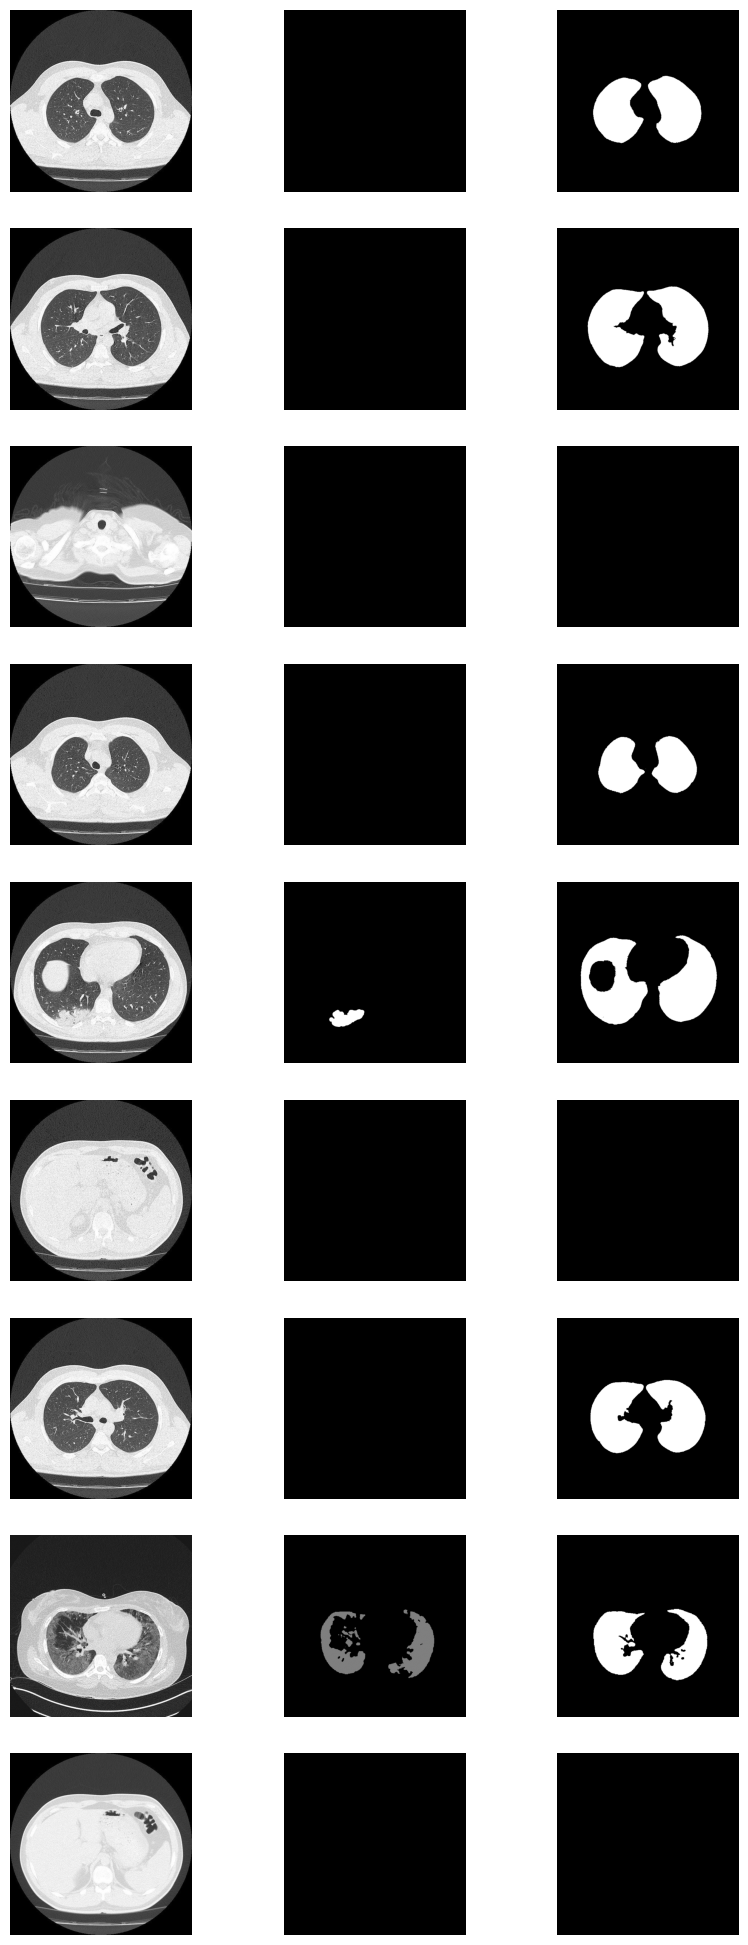

In [7]:
fig, axs = plt.subplots(9, 3, figsize=(10, 25))
i, j = 0, 0
for dicom_path in dicoms:
    infection_mask_path = DATASET_ROOT / 'InfectionMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
    lung_mask_path = DATASET_ROOT / 'LungMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
    
    dcm = dcmread(dicom_path)  # Veja: https://pydicom.github.io/pydicom/dev/index.html
    infection_mask = cv2.imread(infection_mask_path, cv2.IMREAD_GRAYSCALE)
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)

    
    # Correção
    infection_mask = cv2.flip(infection_mask, 0)
    infection_mask = cv2.rotate(infection_mask, cv2.ROTATE_90_CLOCKWISE)
    lung_mask = cv2.flip(lung_mask, 1)
    
    
    pixel_array = dcm.pixel_array  # Veja: https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.pixels.pixel_array.html

    axs[i][j].imshow(pixel_array, cmap='gray'); axs[i][j].axis('off');
    j += 1
    axs[i][j].imshow(infection_mask, cmap='gray'); axs[i][j].axis('off');
    j += 1
    axs[i][j].imshow(lung_mask, cmap='gray'); axs[i][j].axis('off');
    j = 0
    
    i += 1

### Divisão do conjunto de dados:

In [55]:
dicom_paths = sorted(DATASET_ROOT.glob('OpenSourceDCMs/DCM*/*'))

dicom_paths_train, dicom_paths_test = model_selection.train_test_split(dicom_paths, random_state=42, shuffle=True, test_size=0.3)

In [57]:
dicom_paths_validation = dicom_paths_test[:len(dicom_paths_test)//2]
dicom_paths_test = dicom_paths_test[(len(dicom_paths_test)//2):]

In [63]:
print('len(dicom_paths_train):', len(dicom_paths_train))
print('len(dicom_paths_validation):', len(dicom_paths_validation))
print('len(dicom_paths_test):', len(dicom_paths_test))

len(dicom_paths_train): 580
len(dicom_paths_validation): 124
len(dicom_paths_test): 125


In [78]:
def salvar_csv(paths, nome_arquivo):
    with open(nome_arquivo, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['dicom_path', 'infection_mask_path', 'lung_mask_path'])  # Cabeçalho
        for path in paths:
            # dicom_path = path.relative_to(DATASET_ROOT.parent)
            dicom_path = path
            infection_mask_path = DATASET_ROOT /'InfectionMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
            lung_mask_path = DATASET_ROOT / 'LungMasks'/ (dicom_path.stem.split('-')[-1] + '_z' +  dicom_path.stem.split('-')[1][2:] + '.png')
                 
            writer.writerow([dicom_path, infection_mask_path, lung_mask_path])

salvar_csv(dicom_paths_train, 'L3netDemoData_Divisao/train.csv')
salvar_csv(dicom_paths_validation, 'L3netDemoData_Divisao/valid.csv')
salvar_csv(dicom_paths_test, 'L3netDemoData_Divisao/test.csv')